*Import Libraries*

In [0]:
import numpy as np
import scipy as sp
import json
import cv2
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
%matplotlib inline
# from scipy.misc import imresize
import tensorflow.keras as keras
from tensorflow.keras.models import load_model

*Load model*

In [0]:
model3 = load_model('/content/drive/My Drive/Colab Notebooks/A_Q3/model3.h5')
input_shape = (32, 32, 1)

*Show Input Image*

(2139, 1426)


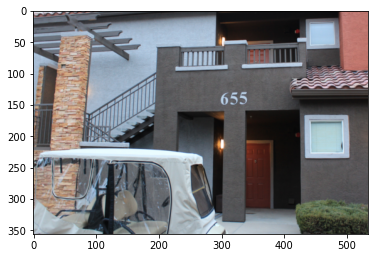

In [0]:
filepath = '/content/drive/My Drive/Colab Notebooks/A_Q3/Test_CNN/3.jpg'
frac = .25
orig_img = Image.open(filepath)
print(orig_img.size)
orig_img = orig_img.resize((int(orig_img.size[0]*frac), int(orig_img.size[1]*frac)), Image.BILINEAR)
figure = plt.figure(num=None, figsize=(6,6))
plt.imshow(orig_img)

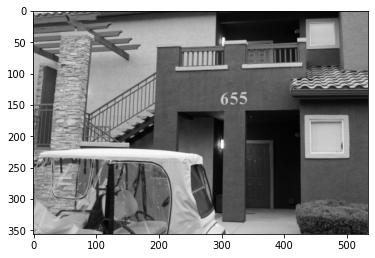

In [0]:
gray_img = (orig_img.convert('L'))
figure = plt.figure(num=None, figsize=(6,6))
plt.imshow(gray_img, cmap='gray')

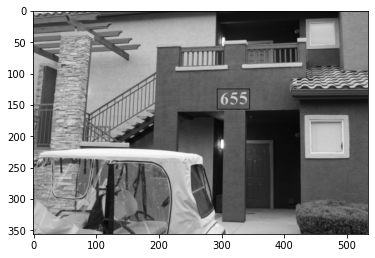

In [0]:
img_copy = gray_img.copy()
draw = ImageDraw.Draw(img_copy)
x, y = 293, 125
draw.rectangle([x, y, x+52, y+32])
# del draw
figure = plt.figure(num=None, figsize=(6,6))
plt.imshow(img_copy, cmap='gray')

In [0]:
img = np.array(gray_img)

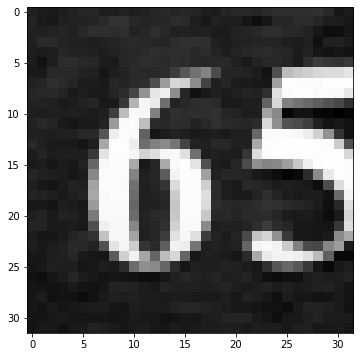

In [0]:
h = input_shape[0]
w = input_shape[1]
cut = img[y:y+h, x:x+w]
figure = plt.figure(num=None, figsize=(6,6))
plt.imshow(cut, cmap='gray')

In [0]:
cut = cv2.resize(cut, (32,32), interpolation=cv2.INTER_AREA)
cut.shape

(32, 32)

*Crop Image for increase Accuracy*

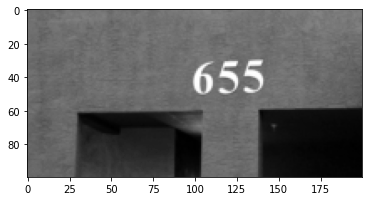

In [0]:
img = img[100:200,200:400]
figure = plt.figure(num=None, figsize=(6,6))
plt.imshow(img, cmap='gray')

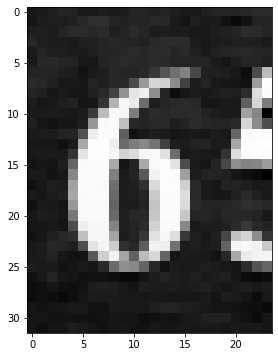

In [0]:
img1 = img[25:25+32,95:95+24]
figure = plt.figure(num=None, figsize=(6,6))
plt.imshow(img1, cmap='gray')

In [0]:
def classify_cut(cut, model=model3):
    sample = cut.astype(np.float32) / np.max(cut)
    sample = sample.reshape((1, *input_shape))
    
    pred = model.predict(sample)
    label = pred.argmax(axis=1)[0]
    p = np.max(pred)
    
    return label, p

*Bounding Boxes*

In [0]:
boxes = []
h = input_shape[0]
w = input_shape[1]
input_shape = (32,32,1)
for y in range(0, img.shape[0]-h, 5):
    for x in range(0, img.shape[1]-w, 5):
        cut = img[y:y+h, x:x+w]
        cut = cv2.resize(cut, (32,32), interpolation = cv2.INTER_AREA)
        label, p = classify_cut(cut)
        if label != 10 and p > 0.7:
            boxes.append({
                'x': x, 'y': y,
                'w': w, 'h': h,
                'label': label,
                'p': p
            })
boxes

[{'h': 32, 'label': 6, 'p': 0.7277118, 'w': 32, 'x': 90, 'y': 20},
 {'h': 32, 'label': 5, 'p': 0.7399036, 'w': 32, 'x': 120, 'y': 20},
 {'h': 32, 'label': 3, 'p': 0.82231337, 'w': 32, 'x': 125, 'y': 20},
 {'h': 32, 'label': 5, 'p': 0.76545405, 'w': 32, 'x': 105, 'y': 30},
 {'h': 32, 'label': 5, 'p': 0.7441701, 'w': 32, 'x': 120, 'y': 30},
 {'h': 32, 'label': 1, 'p': 0.75493354, 'w': 32, 'x': 125, 'y': 50},
 {'h': 32, 'label': 1, 'p': 0.7541114, 'w': 32, 'x': 120, 'y': 55},
 {'h': 32, 'label': 1, 'p': 0.87305295, 'w': 32, 'x': 125, 'y': 60},
 {'h': 32, 'label': 1, 'p': 0.80786055, 'w': 32, 'x': 125, 'y': 65}]

In [0]:
len(boxes)

9

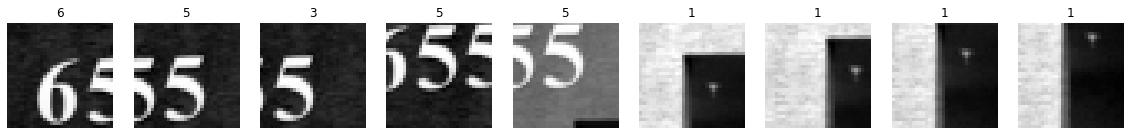

In [0]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=int(len(boxes)))

for i in range(len(boxes)):
    x = boxes[i]['x']
    y = boxes[i]['y']
    w = boxes[i]['w']
    h = boxes[i]['h']
    label = boxes[i]['label']
    cut = img[y:y+h, x:x+w]
    
    ax[i].axis('off')
    ax[i].imshow(cut, cmap='gray')
    ax[i].set_title(label, loc='center')

*Non Maximum Suppresion*

In [0]:
def non_max_suppression(boxes, overlapThresh):
    if len(boxes) == 0:
        return boxes
    
    pick = []
    
    x1 = np.array([box['x'] for box in boxes])
    y1 = np.array([box['y'] for box in boxes])
    x2 = np.array([box['x'] + box['w'] for box in boxes])
    y2 = np.array([box['y'] + box['h'] for box in boxes])
    p = np.array([box['p'] for box in boxes])
    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(p)
    
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        
        for pos in range(0, last):
            j = idxs[pos]
 
            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
 
            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
 
            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]
 
            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)
 
        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)
 
    # return only the bounding boxes that were picked
    suppressed_boxes = [boxes[idx] for idx in np.sort(pick)]
    return suppressed_boxes

In [0]:
suppressed_boxes = non_max_suppression(boxes, 0.5)
suppressed_boxes

[{'h': 32, 'label': 6, 'p': 0.7277118, 'w': 32, 'x': 90, 'y': 20},
 {'h': 32, 'label': 3, 'p': 0.82231337, 'w': 32, 'x': 125, 'y': 20},
 {'h': 32, 'label': 5, 'p': 0.76545405, 'w': 32, 'x': 105, 'y': 30},
 {'h': 32, 'label': 1, 'p': 0.87305295, 'w': 32, 'x': 125, 'y': 60}]

In [0]:
len(suppressed_boxes)

4

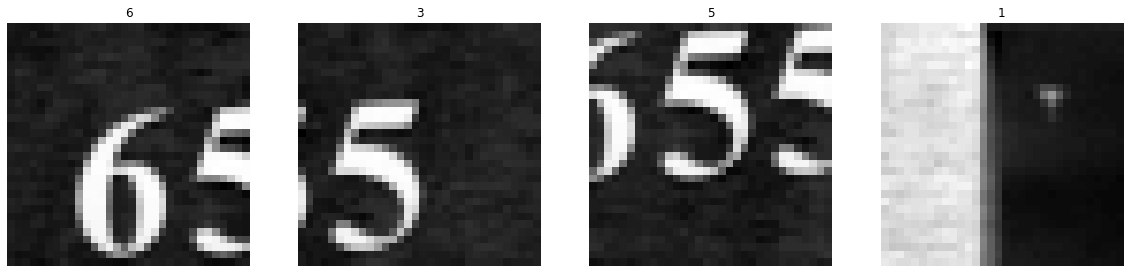

In [0]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=int(len(suppressed_boxes)))

for i in range(len(suppressed_boxes)):
    x = suppressed_boxes[i]['x']
    y = suppressed_boxes[i]['y']
    w = suppressed_boxes[i]['w']
    h = suppressed_boxes[i]['h']
    label = suppressed_boxes[i]['label']
    cut = img[y:y+h, x:x+w]
    
    ax[i].axis('off')
    ax[i].imshow(cut, cmap='gray')
    ax[i].set_title(label, loc='center')

In [0]:
def euc_dist(box1, box2):
    return ((box1['x'] - box2['x'])**2 + (box1['y'] - box2['y'])**2) ** .5

In [0]:
ps = np.array([box['p'] for box in suppressed_boxes])
idx_max = ps.argmax()
box_max = suppressed_boxes[idx_max]
thresh = (box_max['w'] ** 2 + box_max['h'] ** 2) ** .5
sign_boxes = [box_max]
for i in range(len(suppressed_boxes)):
    if i == idx_max:
        continue
        
    if euc_dist(box_max, suppressed_boxes[i]) < thresh:
        sign_boxes.append(suppressed_boxes[i])

xs = np.array([box['x'] for box in sign_boxes])
idxs = np.argsort(xs)
sign_boxes = [sign_boxes[idx] for idx in idxs]
sign_boxes

[{'h': 32, 'label': 5, 'p': 0.76545405, 'w': 32, 'x': 105, 'y': 30},
 {'h': 32, 'label': 1, 'p': 0.87305295, 'w': 32, 'x': 125, 'y': 60},
 {'h': 32, 'label': 3, 'p': 0.82231337, 'w': 32, 'x': 125, 'y': 20}]

(([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

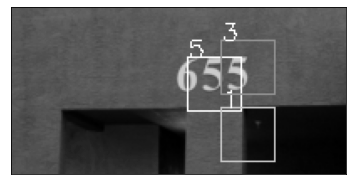

In [0]:
start1  = (sign_boxes[0]['x'], sign_boxes[0]['y'])
start2  = (sign_boxes[1]['x'], sign_boxes[1]['y'])
start3  = (sign_boxes[2]['x'], sign_boxes[2]['y'])

end1 = (sign_boxes[0]['x']+32, sign_boxes[0]['y']+32)
end2 = (sign_boxes[1]['x']+32, sign_boxes[1]['y']+32)
end3 = (sign_boxes[2]['x']+32, sign_boxes[2]['y']+32)

txt1 = str(sign_boxes[0]['label'])
txt2 = str(sign_boxes[1]['label'])
txt3 = str(sign_boxes[2]['label'])
color1 = (255,255,255)
color2 = (200,200,200)
color3 = (150,150,150)

font                   = cv2.FONT_HERSHEY_SIMPLEX
cv2.rectangle(img, start1, end1, color1)
cv2.putText(img, txt1, start1, font, 0.5, 255)
cv2.rectangle(img, start2, end2, color2)
cv2.putText(img, txt2, start2, font, 0.5, 255)
cv2.rectangle(img, start3, end3, color3)
cv2.putText(img, txt3, start3, font,  0.5, 255)
figure = plt.figure(num=None, figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.xticks([]), plt.yticks([])

In [28]:
sign = ''.join([str(box['label']) for box in sign_boxes])
sign

631
